In [2]:
import torch
import math
import time
from cacheLSTM.cacheLSTM import cacheLSTM
from refLSTM import refLSTM

assert torch.cuda.is_available()
cuda_device = torch.device("cuda")

# test each algorithm multiple iters for each test case
test_iters = 10

In [3]:
def testSpeedUp(T, B, Di, Dh):
    # -----------------------------------------------------
    # init inputs
    X = torch.randn(T, B, Di, device=cuda_device)
    h = torch.randn(B, Dh, device=cuda_device)
    C = torch.randn(B, Dh, device=cuda_device)

    # init weights
    Wii = torch.randn(Dh, Di, device=cuda_device)
    Wif = torch.randn(Dh, Di, device=cuda_device)
    Wig = torch.randn(Dh, Di, device=cuda_device)
    Wio = torch.randn(Dh, Di, device=cuda_device)

    Whi = torch.randn(Dh, Dh, device=cuda_device)
    Whf = torch.randn(Dh, Dh, device=cuda_device)
    Whg = torch.randn(Dh, Dh, device=cuda_device)
    Who = torch.randn(Dh, Dh, device=cuda_device)
    
    # ------------------------------------------------------
    # test c-lstm
    clstm = cacheLSTM(Di, Dh)
    clstm_uu = torch.cat([Wii.clone(), Wif.clone(), Wio.clone(), Wig.clone()], 0).transpose(0,1).contiguous()
    clstm_ww = torch.cat([Whi.clone(), Whf.clone(), Who.clone(), Whg.clone()], 0).contiguous()

    clstm.setUW(clstm_uu,clstm_ww)
    clstm = clstm.to(cuda_device)

    # forward
    clstm_forward = 0
    for _ in range(test_iters):
        # prepare input
        clstm_x = X.clone()
        clstm_h = h.clone()
        clstm_c = C.clone()

        # one forward pass
        start = time.time()
        clstm_out_h, clstm_out_c = clstm(clstm_x, clstm_h, clstm_c)    
        torch.cuda.synchronize()
        clstm_forward += time.time() - start

    clstm_forward_us = clstm_forward * 1e6 / T / test_iters
    # get rid of the first in hout which is h0
    clstm_out_x = clstm_out_h[1:,:,:] 
    
    # ========================================
    # test torch lstm on gpu

    lstm = torch.nn.LSTM(Di, Dh, bias=False)
    lstm_uu = torch.cat([Wii.clone(), Wif.clone(), Wig.clone(), Wio.clone()], 0).contiguous()
    lstm_ww = torch.cat([Whi.clone(), Whf.clone(), Whg.clone(), Who.clone()], 0).contiguous()
    lstm.weight_ih_l0 = torch.nn.Parameter(lstm_uu)
    lstm.weight_hh_l0 = torch.nn.Parameter(lstm_ww)
    lstm = lstm.to(cuda_device)

    h0 = h.unsqueeze(0)
    c0 = C.unsqueeze(0)

    # forward
    lstm_gpu_forward = 0
    for _ in range(test_iters):
        # prepare input
        lstm_x = X.clone()
        lstm_h = h0.clone()
        lstm_c = c0.clone()

        # forward pass
        start = time.time()
        lstm_out_x, (lstm_out_h, lstm_out_c) = lstm(lstm_x, (lstm_h, lstm_c)) 
        torch.cuda.synchronize()
        lstm_gpu_forward += time.time() - start

    # ------------------------------------------------------------
    # check correctness
    if not torch.allclose(clstm_out_x, lstm_out_x, rtol=1e-3, atol=1e-3):
        print("lower criteria")
        assert torch.allclose(clstm_out_x, lstm_out_x, rtol=1e-2, atol=1e-2)
    
    # return speedup
    lstm_gpu_forward_us = lstm_gpu_forward * 1e6/T/test_iters
    return lstm_gpu_forward_us / clstm_forward_us

In [4]:
speedups = {}
for Di in [100, 300, 768]:
    for Dh in [16,32,64]: #
        speedups[(Di,Dh)] = []
        for it, T in enumerate([30,100,300,1000,3000]): #
            for ib, B in enumerate([2,4,8,16,32]):
                su = testSpeedUp(T, B, Di, Dh)
                print((T,B,Di,Dh,su))
                speedups[(Di,Dh)].append((it,ib,su))

import pickle

(30, 2, 100, 16, 2.659079240116379)
(30, 4, 100, 16, 2.6661700975081257)
(30, 8, 100, 16, 2.5572580645161294)
(30, 16, 100, 16, 2.6767830045523517)
(30, 32, 100, 16, 2.598180739568915)
(100, 2, 100, 16, 3.3752927400468384)
(100, 4, 100, 16, 3.480903393638406)
(100, 8, 100, 16, 3.4384534761849306)
(100, 16, 100, 16, 3.7298046920143304)
(100, 32, 100, 16, 3.635345503415836)
(300, 2, 100, 16, 4.145029179891471)
(300, 4, 100, 16, 4.85487562948268)
(300, 8, 100, 16, 5.045646103071846)
(300, 16, 100, 16, 5.745878394616679)
(300, 32, 100, 16, 4.136913953919327)
(1000, 2, 100, 16, 4.575136834119113)
(1000, 4, 100, 16, 5.988281740690892)
(1000, 8, 100, 16, 4.482325326932919)
(1000, 16, 100, 16, 4.602195960689161)
(1000, 32, 100, 16, 5.402034976152623)
(3000, 2, 100, 16, 5.099375740307969)
(3000, 4, 100, 16, 5.166278245009626)
(3000, 8, 100, 16, 4.935727331826765)
(3000, 16, 100, 16, 5.729267843178274)
(3000, 32, 100, 16, 5.055078416728903)
(30, 2, 100, 32, 2.3559975644408357)
(30, 4, 100, 32, 2

(1000, 8, 768, 64, 2.3782681683969904)
(1000, 16, 768, 64, 2.3052494572542725)
(1000, 32, 768, 64, 1.4868473221070717)
(3000, 2, 768, 64, 2.5767301288465347)
(3000, 4, 768, 64, 2.560108262046327)
(3000, 8, 768, 64, 2.434536655745589)
(3000, 16, 768, 64, 2.3163194325463454)
(3000, 32, 768, 64, 1.5279572335128506)


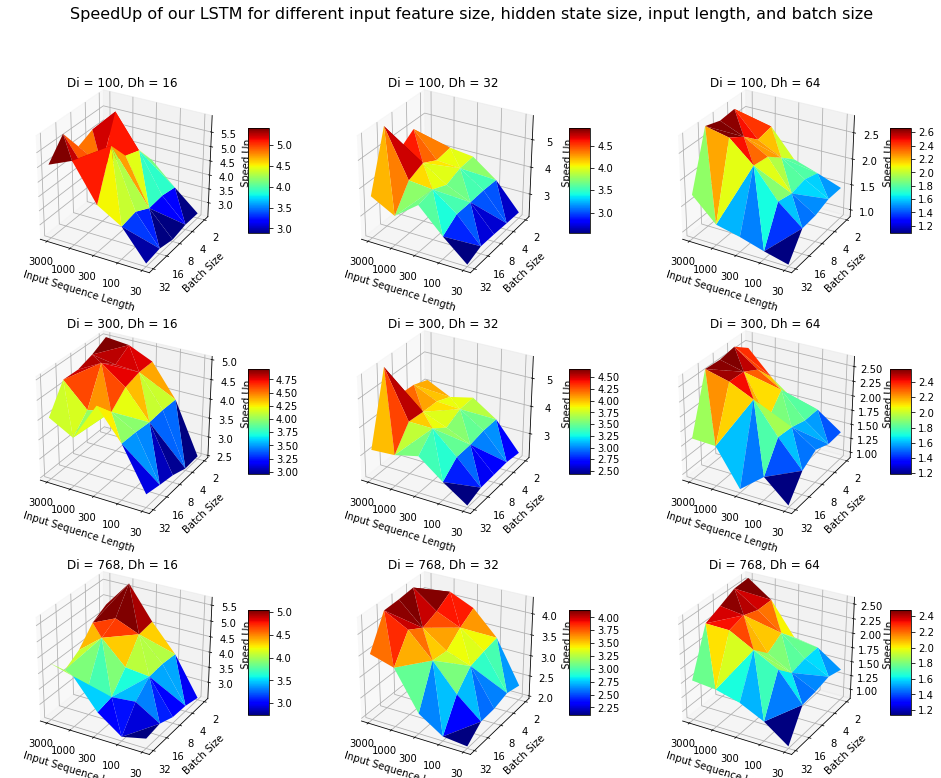

In [21]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import griddata

fig = plt.figure(figsize=(16,12))
#fig.tight_layout()

for i, Di in enumerate([100, 300, 768]):
    for j, Dh in enumerate([16,32,64]):
        ax = fig.add_subplot(3, 3, 1 + 3 * i + j, projection='3d')
        # create 1D-arrays from the 2D-arrays
        x = []
        y = []
        z = []
        for it,ib,su in speedups[(Di,Dh)]:
            x = [it] + x
            y = [ib] + y
            z.append(su)
        xyz = {'x': x, 'y': y, 'z': z}

        df = pd.DataFrame({'x': x, 'y': y, 'z': z})


        #ax = Axes3D(fig)
        surf = ax.plot_trisurf(df.x, df.y, df.z, cmap=cm.jet, linewidth=0.1)
        fig.colorbar(surf, shrink=0.5, aspect=5)
        ax.set_xlabel('Input Sequence Length')
        ax.set_ylabel('Batch Size')
        ax.set_zlabel('Speed Up')
        ax.set_xticklabels(['3000', '1000', '300', '100', '30'])
        ax.set_yticklabels(['32', '16', '8', '4', '2'])
        ax.set_xticks([0,1,2,3,4])
        ax.set_yticks([0,1,2,3,4])
        ax.set_title('Di = {}, Dh = {}'.format(Di,Dh))
        #ax.set_zticks([0,1,2,3,4,5,6,7,8])

start = 0.1
end = 0.9
margin = 0.15
fig.subplots_adjust(left=start, bottom=start, right=end, top=end, wspace=margin, hspace=margin)
fig.suptitle('SpeedUp of our LSTM for different input feature size, hidden state size, input length, and batch size', fontsize=16)
plt.savefig('teste.png')
plt.show()